In [15]:
# Import modules
import pandas as pd
import scanpy as sc
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import scipy.sparse as sp
from tqdm.auto import tqdm
from scipy.stats.contingency import crosstab
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the datasets
path_file = '8_Classifiers/Data/Input/adata_myeloid.h5ad'

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 182934 × 10
    obs: 'UMAP1', 'UMAP2', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'cell_type', 'louvain_None', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'myeloid_cell_type', 'myeloid_louvain_None', 'myeloid_louvain_0.4', 'myeloid_louvain_0.6', 'myeloid_louvain_1.0', 'myeloid_louvain_1.4', 'myeloid_louvain_1.6', 'myeloid_louvain_1.8', 'myeloid_louvain_2.0', 'myeloid_louvain_1.2', 'predicted_type_1.0', 'predicted_type_1.2', 'predicted_type_1.4', 'predicted_type_1.6', 'predicted_type_1.8', 'predicted_type_2.0'
    var: 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'louvain_None', 'myeloid_cell_type_colors', 'myeloid_louvain_0.4', 'myeloid_louvain_0.4_colors', 'myeloid_louvain_0.6', 'myeloid_louvain_0.6_colors',

In [3]:
# Set X and Y
X = adata.X
Y = adata.obs['myeloid_cell_type']

In [4]:
# Split into traiing and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=42)

In [ ]:
# Create an array of indices for all cells
all_indices = np.arange(X.shape[0])

# Split indices, keeping track of which are train/test
train_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.1,
    stratify=Y,
    random_state=42)

# Use indices to subset X and Y
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

/tmp/ipykernel_3778853/1870435252.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_train, Y_test = Y[train_idx], Y[test_idx]


In [ ]:
print('Original class distribution:\n', pd.Series(Y).value_counts(normalize=True))
print('\nTraining class distribution:\n', pd.Series(Y_train).value_counts(normalize=True))
print('\nTraining class counts:\n', pd.Series(Y_train).value_counts())

Original class distribution:
 myeloid_cell_type
Macrophages    0.880301
Monocytes      0.064083
Rest           0.029978
Neutrophils    0.018652
DCs            0.006937
Mast Cells     0.000049
Name: proportion, dtype: float64

Training class distribution:
 myeloid_cell_type
Macrophages    0.880302
Monocytes      0.064085
Rest           0.029974
Neutrophils    0.018653
DCs            0.006936
Mast Cells     0.000049
Name: proportion, dtype: float64

Training class counts:
 myeloid_cell_type
Macrophages    144933
Monocytes       10551
Rest             4935
Neutrophils      3071
DCs              1142
Mast Cells          8
Name: count, dtype: int64


In [ ]:
# Define parameter grid
param_grid = {
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 1e-3, 1e-2, 1e-1],
    'svc__decision_function_shape': ['ovr', 'ovo'],
    'svc__probability': [True]}

# Use a pipeline to standardize and apply SVC
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', SVC(random_state=42))])

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for SVC
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2)

# Fit the model
grid_search.fit(X_train, Y_train)

# Evaluate
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='weighted')

# Output
print(f"Best SVM Params: {grid_search.best_params_}")
print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}")
print('Classification Report:\n', classification_report(Y_test, Y_pred))

# Save the model
joblib.dump(best_model, '8_Classifiers/Models/best_svm_model.pkl')

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END svc__C=1, svc__decision_function_shape=ovr, svc__gamma=auto, svc__kernel=poly, svc__probability=True; total time= 8.3min
[CV] END svc__C=0.1, svc__decision_function_shape=ovr, svc__gamma=scale, svc__kernel=linear, svc__probability=True; total time=10.2min
[CV] END svc__C=0.1, svc__decision_function_shape=ovr, svc__gamma=scale, svc__kernel=linear, svc__probability=True; total time=10.3min
[CV] END svc__C=1, svc__decision_function_shape=ovr, svc__gamma=scale, svc__kernel=linear, svc__probability=True; total time= 9.2min
[CV] END svc__C=1, svc__decision_function_shape=ovr, svc__gamma=scale, svc__kernel=linear, svc__probability=True; total time= 9.2min
[CV] END svc__C=1, svc__decision_function_shape=ovr, svc__gamma=scale, svc__kernel=linear, svc__probability=True; total time= 9.5min
[CV] END svc__C=1, svc__decision_function_shape=ovr, svc__gamma=auto, svc__kernel=poly, svc__probability=True; total time= 9.1min
[CV] END

In [ ]:
clf = joblib.load('8_Classifiers/Models/best_svm_model.pkl')

In [6]:
Y_pred = clf.predict(X[test_idx])
Y_test = Y[test_idx]

/tmp/ipykernel_3778853/877887143.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_test = Y[test_idx]


In [7]:
# Get obs_names (row labels) for test set
test_obs_names = adata.obs_names[test_idx]

# Assign NaNs first
adata.obs['svm_predicted_cell_type'] = np.nan

# Now assign predictions using aligned obs_names
adata.obs.loc[test_obs_names, 'svm_predicted_cell_type'] = Y_pred

/tmp/ipykernel_3778853/4087268358.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Macrophages' 'Macrophages' 'Macrophages' ... 'Macrophages' 'DCs'
 'Macrophages']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[test_obs_names, 'svm_predicted_cell_type'] = Y_pred


In [ ]:
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='weighted')

#print(f"\nBest Params: {grid_search.best_params_}")
print(f"Accuracy on test set: {acc:.3f}")
print(f"F1 score on test set: {f1:.3f}")
print('\nClassification Report:\n', classification_report(Y_test, Y_pred))

Accuracy on test set: 0.999
F1 score on test set: 0.999

Classification Report:
               precision    recall  f1-score   support

         DCs       0.98      0.99      0.99       127
 Macrophages       1.00      1.00      1.00     16104
  Mast Cells       1.00      1.00      1.00         1
   Monocytes       1.00      1.00      1.00      1172
 Neutrophils       1.00      1.00      1.00       341
        Rest       1.00      0.99      0.99       549

    accuracy                           1.00     18294
   macro avg       1.00      1.00      1.00     18294
weighted avg       1.00      1.00      1.00     18294



In [ ]:
adata.write_h5ad('8_Classifiers/Data/Input/pred_adata_myeloid_.h5ad')

In [ ]:
# Load the datasets
path_file = '8_Classifiers/Data/Input/pred_adata_myeloid_.h5ad'

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 182934 × 10
    obs: 'UMAP1', 'UMAP2', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'cell_type', 'louvain_None', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'myeloid_cell_type', 'myeloid_louvain_None', 'myeloid_louvain_0.4', 'myeloid_louvain_0.6', 'myeloid_louvain_1.0', 'myeloid_louvain_1.4', 'myeloid_louvain_1.6', 'myeloid_louvain_1.8', 'myeloid_louvain_2.0', 'myeloid_louvain_1.2', 'predicted_type_1.0', 'predicted_type_1.2', 'predicted_type_1.4', 'predicted_type_1.6', 'predicted_type_1.8', 'predicted_type_2.0', 'svm_predicted_cell_type'
    var: 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'louvain_None', 'myeloid_cell_type_colors', 'myeloid_louvain_0.4', 'myeloid_louvain_0.4_colors', 'myeloid_louvain_0.6', 'm

In [11]:
# Plot the results with only the predicted cell types and not the NaNs
# Select only rows where prediction is not NaN
mask = adata.obs['svm_predicted_cell_type'].notna()

# Extract true and predicted labels for test cells
true_labels = adata.obs.loc[mask, 'myeloid_cell_type']
pred_labels = adata.obs.loc[mask, 'svm_predicted_cell_type']

In [13]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[  126     1     0     0     0     0]
 [    0 16104     0     0     0     0]
 [    0     0     1     0     0     0]
 [    1     2     0  1167     0     2]
 [    0     0     0     0   341     0]
 [    1     5     0     0     1   542]]
              precision    recall  f1-score   support

         DCs       0.98      0.99      0.99       127
 Macrophages       1.00      1.00      1.00     16104
  Mast Cells       1.00      1.00      1.00         1
   Monocytes       1.00      1.00      1.00      1172
 Neutrophils       1.00      1.00      1.00       341
        Rest       1.00      0.99      0.99       549

    accuracy                           1.00     18294
   macro avg       1.00      1.00      1.00     18294
weighted avg       1.00      1.00      1.00     18294



<Axes: >

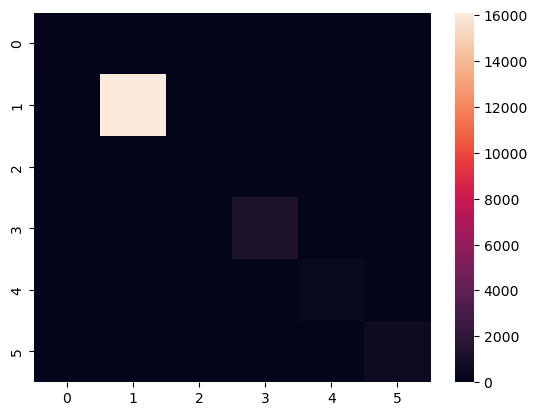

In [16]:
sns.heatmap(crosstab(list(true_labels.values), list(pred_labels.values)).count)

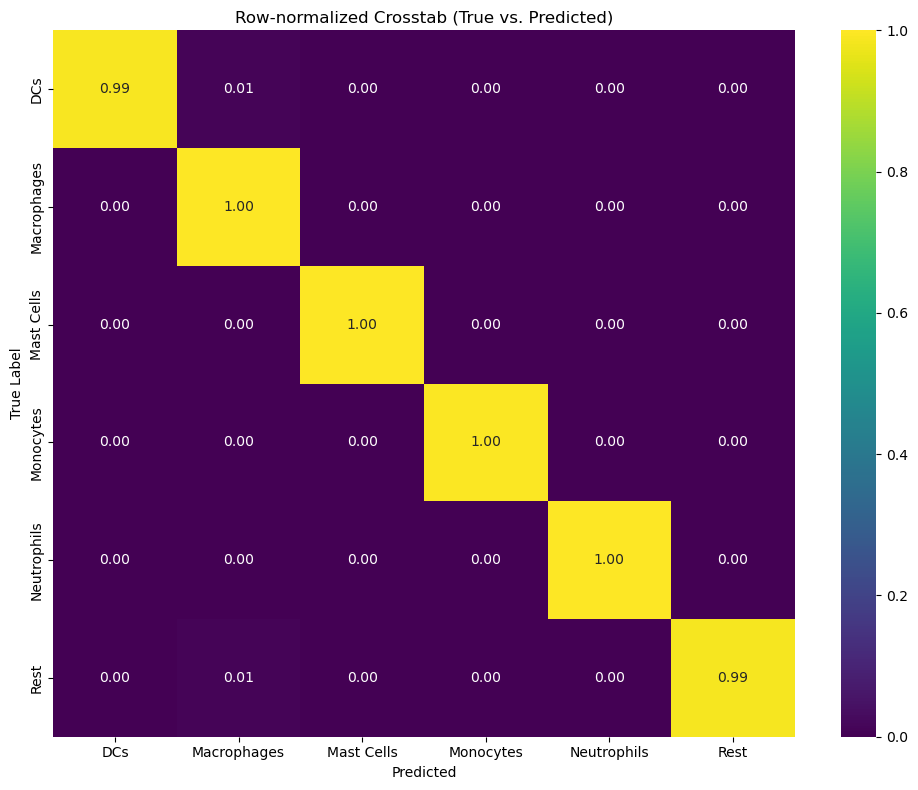

In [ ]:
# Row normalize the true labels to show the performance of classification for each class
ct_normalized = pd.crosstab(true_labels, pred_labels, normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(ct_normalized, cmap='viridis', annot=True, fmt='.2f')
plt.title('Row-normalized Crosstab (True vs. Predicted)')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()